# Purpose


### 2023-05-31
**New in this notebook:**
Instead of doing the ranking and reshaping in pandas/polars, I'll 
- Save the raw inference data to a stating table in BQ
- Run a BQ query to
    - Create the rank column (in a CTE)
    - Reshape the data to the desired target format
    - Insert it into a staging table (`tmp` table for gazette inference?)
    - Copy partition from stating table to prod table
    
By inserting data into the staging table, we ensure that the model outputs match the prod outputs and reduce the chance of blasting data from the prod table.

---

***General steps**
- Pull data for inference from GCS
- Load best model from previous run 
- Run inference on large 1k subreddits (r/de, r/ich_iel, r/fragreddit)
    - Save inference data (raw)


- Reshape data for cache
    - 1 row = subreddit + country + subscribed status. Examples:
        - r/`de` | DE (Germany) | 1 (Subscribed) | {Nested struct of top N users}
        - r/`de` | DE (Germany) | 0 (viewed, but NOT Subscribed) |  {Nested struct of top N users}
        
Open questions:
- Other Geos: For now we'll exclude them because ROW can take up a lot of inference & processing time
    - How do we handle users that have NULL/no Geo?
        - Exclude them
    - How do we handle users from non-target Geos?
        - Exclude them

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import glob
import logging
from logging import info
import os
from pathlib import Path
import json
from typing import List, Union

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
import joblib
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, joblib, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
joblib		v: 1.0.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228


# Pick top model & upload it to GCS
We'll want to move it to GCS so that we can recover it in kubeflow or elsewhere to run inference in parallel

In [5]:
path_inference_model = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024")

gcs_inf_model_upload_dir = f"gs://i18n-subreddit-clustering/data/models/pn_model/{path_inference_model.name}"
gcs_inf_model_upload_dir

'gs://i18n-subreddit-clustering/data/models/pn_model/pn_manual_test_2023-05-30_153024'

In [6]:
!ls $path_inference_model

X_test-172807_47.parquet	    model-rf_pre1-train_806431_40.gz
X_train-806431_47.parquet	    model-xgboost-train_20000_40.gz
X_validate-172807_47.parquet	    model-xgboost-train_806431_40.gz
df_train-1152045_52.parquet	    model-xgboost_pre1-train_20000_40.gz
model-hgbc_pre1-train_20000_40.gz   model-xgboost_pre1-train_806431_40.gz
model-hgbc_pre1-train_806431_40.gz  y_test-172807_1.parquet
model-rf-train_20000_40.gz	    y_train-806431_1.parquet
model-rf-train_806431_40.gz	    y_validate-172807_1.parquet
model-rf_pre1-train_20000_40.gz


In [7]:
!echo gsutil -m cp -r $path_inference_model $gcs_inf_model_upload_dir

gsutil -m cp -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024 gs://i18n-subreddit-clustering/data/models/pn_model/pn_manual_test_2023-05-30_153024


In [8]:
# !gsutil -m cp -r $path_inference_model $gcs_inf_model_upload_dir

# Load Model & Get list of columns used for training

In [9]:
%%time

model_path = f"{path_inference_model}/model-xgboost_pre1-train_806431_40.gz"
model = joblib.load(
    model_path
)

model

CPU times: user 3.63 s, sys: 11.6 ms, total: 3.64 s
Wall time: 163 ms


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['screen_view_count_14d_log',
                                                                          'user_receives_pn_subreddit_count_t7',
                                                                          'user_receives_pn_t7',
                                                                          'user_receives_pn_t14',
                                                                          'user_receives_pn_t30',
                                                                          'log_user_clicks_pn_...
       

In [10]:
# Get input feature names for modeling
l_feature_names = [
    '__'.join(_.split('__')[1:]) for _ in model.best_estimator_['preprocess'].get_feature_names_out()
]
print(
    f"{len(l_feature_names)} <- Model feature count"
    f"\nFeatures:"
    f"\n  {l_feature_names}"
)

40 <- Model feature count
Features:
  ['screen_view_count_14d_log', 'user_receives_pn_subreddit_count_t7', 'user_receives_pn_t7', 'user_receives_pn_t14', 'user_receives_pn_t30', 'log_user_clicks_pn_t7', 'log_user_clicks_trnd_t7', 'log_post_consumes_30', 'log_num_post_consumes_home_30', 'pct_post_consumes_home_30', 'pct_post_consumes_community_30', 'pct_post_consumes_post_detail_30', 'pct_post_consumes_ios_30', 'pct_post_consumes_android_30', 'pct_post_consumes_nsfw_30', 'num_post_consumes_ios_30', 'num_post_consumes_android_30', 'sub_dau_perc_l28', 'perc_by_country_sd', 'us_screenviews_l14_log', 'us_distinct_posts_viewed_l14_log', 'us_post_screenviews_l14_log', 'us_trend_pn_receive_l14_log', 'us_days_active_ios_l30_pct', 'us_android_days_active_l30_pct', 'us_upvotes_l14', 'us_comments_l14', 'us_posts_l14', 'us_trend_pn_click_l14', 'us_sessions_l14', 'us_ios_days_active_l30', 'us_android_days_active_l30', 'us_days_active_l30', 'users_log_l28', 'seo_users_pct_l28', 'loggedin_users_pct_l2

In [11]:
%%time

# We also need these columns to save the outputs (even if not used for inference directly)
c_user_geo_col = 'user_geo_country_code'
l_ix_cols = [
    'pt',
    'target_subreddit',
    'target_subreddit_id',
    'subscribed',
    c_user_geo_col,  # We'll maybe need to rename it in final table?
    'user_id',
]

# Each row in output table will be at this grain:
l_ix_cache = [
    'pt',
    'target_subreddit_id',
    'target_subreddit',
    'subscribed',
    c_user_geo_col,  # We'll maybe need to rename it in final table?
]

# Other columns for output: These we'll create as part of inference
c_pred_proba = 'click_proba'
#   TODO(djb): this rank also needs to be at SUBSCRIPTION level! subscribers & non-subscribers will have a different rank!
c_user_rank = 'user_rank_by_sub_and_geo'  

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


In [12]:
# columns to query in BQ table:
set(l_ix_cols + l_feature_names)

{'android_users_pct_l28',
 'ios_users_pct_l28',
 'legacy_user_cohort_ord',
 'log_num_post_consumes_home_30',
 'log_post_consumes_30',
 'log_user_clicks_pn_t7',
 'log_user_clicks_trnd_t7',
 'loggedin_users_pct_l28',
 'num_post_consumes_android_30',
 'num_post_consumes_ios_30',
 'pct_post_consumes_android_30',
 'pct_post_consumes_community_30',
 'pct_post_consumes_home_30',
 'pct_post_consumes_ios_30',
 'pct_post_consumes_nsfw_30',
 'pct_post_consumes_post_detail_30',
 'perc_by_country_sd',
 'pt',
 'screen_view_count_14d_log',
 'seo_users_pct_l28',
 'sub_dau_perc_l28',
 'subscribed',
 'target_subreddit',
 'target_subreddit_id',
 'us_android_days_active_l30',
 'us_android_days_active_l30_pct',
 'us_comments_l14',
 'us_days_active_ios_l30_pct',
 'us_days_active_l30',
 'us_distinct_posts_viewed_l14_log',
 'us_ios_days_active_l30',
 'us_post_screenviews_l14_log',
 'us_posts_l14',
 'us_screenviews_l14_log',
 'us_sessions_l14',
 'us_trend_pn_click_l14',
 'us_trend_pn_receive_l14_log',
 'us_upv

# Load & reshape data

## Export data to GCS

Here we'll export a SAMPLE so we can test the process before running on 26k subreddits

In [13]:
# %%time
# %%bigquery _ --project data-prod-165221/ 

# -- ============
# -- Export data to GCS because querying such a huge table takes forever and a half
# -- ===
# EXPORT DATA OPTIONS(
#     uri='gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/*.parquet',
#     format='PARQUET',
#     overwrite=true
# ) AS

# SELECT
#     pt, target_subreddit, target_subreddit_id, subscribed, user_geo_country_code, user_id
#     , screen_view_count_14d_log, user_receives_pn_subreddit_count_t7, user_receives_pn_t7
#     , user_receives_pn_t14, user_receives_pn_t30, log_user_clicks_pn_t7, log_user_clicks_trnd_t7
#     , log_post_consumes_30, log_num_post_consumes_home_30, pct_post_consumes_home_30, pct_post_consumes_community_30, pct_post_consumes_post_detail_30, pct_post_consumes_ios_30
#     , pct_post_consumes_android_30, pct_post_consumes_nsfw_30, num_post_consumes_ios_30
#     , num_post_consumes_android_30, sub_dau_perc_l28, perc_by_country_sd, us_screenviews_l14_log
#     , us_distinct_posts_viewed_l14_log, us_post_screenviews_l14_log, us_trend_pn_receive_l14_log
#     , us_days_active_ios_l30_pct, us_android_days_active_l30_pct, us_upvotes_l14, us_comments_l14
#     , us_posts_l14, us_trend_pn_click_l14, us_sessions_l14, us_ios_days_active_l30
#     , us_android_days_active_l30, us_days_active_l30, users_log_l28, seo_users_pct_l28
#     , loggedin_users_pct_l28, ios_users_pct_l28, android_users_pct_l28, legacy_user_cohort_ord
# FROM `reddit-employee-datasets.david_bermejo.pn_ft_all_20230530` AS f
#     INNER JOIN (
#         -- Pick top subreddits for sampling/testing
#         SELECT
#             s.subreddit_id, s.subreddit_name
#             , ROW_NUMBER() OVER(ORDER BY users_l7 DESC) AS rank_by_users
#         FROM `reddit-employee-datasets.david_bermejo.pn_ft_subreddits_20230525` AS s

#         WHERE s.pt = '2023-05-29'
#         -- For testing, we can limit to only the top subreddits
#         QUALIFY (
#             rank_by_users <= 2000
#             OR subreddit_name LIKE "%street%"
#             OR subreddit_name LIKE "%figther%"
#         )
#     ) AS sub
#         ON f.target_subreddit_id = sub.subreddit_id

# WHERE pt = '2023-05-29'
# ;



## Download training data from GCS

Here we mostly copy the query used for training. Note that we should match column names.

We uset GCS instead of pulling from BigQuery to save time. We also sync data with `gsutil` instead of trying to read directly from GCS

for 1k subreddits:
- ~1,800 files
- ~50 GB
- ~10 minutes to download with `gsutil`

For 2k subreddits:
- 5,000 files
- ~198 GB
- ~25 minutes to download with `gsutil`


In [14]:
bucket_name = 'i18n-subreddit-clustering'
gcs_inference = f"gs://{bucket_name}/pn_model/runs/inference/20230529_sample/"

path_local_cache = Path(f"/home/jupyter/subreddit_clustering_i18n/data/local_cache/{bucket_name}/")
local_path_inference = path_local_cache / gcs_inference.split(f"{bucket_name}/")[1]
Path.mkdir(local_path_inference, exist_ok=True, parents=True)

print(gcs_inference)
print(local_path_inference)

gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/
/home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample


In [15]:
# !gsutil ls $gcs_inference

In [16]:
# delete in case we exported the wrong data
## !echo gsutil -m rm -r gcs_inference

In [17]:
# try -q (quiet) mode at the end to suppress progress & file list
#. This can be helpful when we have 2k+ files b/c gsutil can overwhelm/freeze the system
#. also try a lower process count (20 seems to freeze, maybe try 10?)

!echo gsutil -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r -n $gcs_inference $local_path_inference
print('\n')

!echo gsutil -q -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r $gcs_inference $local_path_inference
!echo gsutil -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r $gcs_inference $local_path_inference

gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample -q


gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample -q


# Run inference - each file in parallel
For running inference we require pandas because it's the format sklearn/XGBoost expects for inputs. 

~~Because we can't use `polars` for parallel processing, let's just process & run inference on each file individually.
Then, once we've run inference on all files we can move to polars for ranking and clipping, which polars can do well in parallel.~~

NEW: 
<br>forget using polars for post-processing/reshaping! Instead load the raw inference to BQ and then rank & reshape there!

---

ETAs for only `inference` & `save`:
- 0:49 (hh:mins): 47,055,198.9 rows / min | `2,305,704,745` rows with pandas + paralle with `dask` (5k files)
- 1:42 (hh:mins): 22,604,948.5 rows / min | `2,305,704,745` rows with pandas in series [1 file at a time] (5k files)
- 0:21 (hh:mins): 33,617,303.5 rows / min | `0,705,963,374` rows with pandas (1 file)


```bash
# `2,305,704,745` rows with pandas in SERIES [1 file at a time]
42/5000 [00:50<1:41:02, 1.22s/it]

# ---

# `2,305,704,745` rows with pandas in PARALLEL
CPU times: user 15h 54min 6s, sys: 1h 7min 58s, total: 17h 2min 5s
Wall time: 49min 7s

# ---

# Read data. `705,963,374` rows with pandas
CPU times: user 7min 59s, sys: 5min 1s, total: 13min 1s
Wall time: 26 s
(705963374, 26)

# Run inference
18:33:47 | INFO | "Create new df for predictions..."
18:47:44 | INFO | "Done with predictions"
CPU times: user 3h 54min 39s, sys: 3min 2s, total: 3h 57min 41s
Wall time: 13min 56s

# Save inference file (note it might take longer b/c I also added rank column in the previous step)
20:44:55 | INFO | "start saving predictions..."
CPU times: user 5min 45s, sys: 31.3 s, total: 6min 17s
Wall time: 6min 24s
```

To check progress manually, we can run this command from the CLI to count the number of output files:

```bash
ls "/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/" -l | wc -l
# 1473
```

In [62]:
from subclu.pn_models.pn_inference import run_inference_on_one_file

CPU times: user 0 ns, sys: 1.9 ms, total: 1.9 ms
Wall time: 3.53 ms


In [51]:
%%time

f_list = glob.glob(f"{local_path_inference}/*.parquet")
print(len(f_list))
f_list[:1]

5000
CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 15.8 ms


['/home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/000000004226.parquet']

In [47]:
# define inference path once so that it's the same for all output files
path_this_model_inference = path_this_model / 'inference'

for f_ in tqdm(f_list[:1]):
    run_inference_on_one_file(
        df_path=f_,
        model_path=model_path,
        path_output=path_this_model_inference,
        l_ix_columns=l_ix_cols,
        l_feature_columns=None,
        verbose=False,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

19:09:52 | INFO | "Loading model...
  /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-xgboost_pre1-train_806431_40.gz"
19:09:52 | INFO | "40 <- Model feature count"
19:09:52 | INFO | "
Features:
  ['screen_view_count_14d_log', 'user_receives_pn_subreddit_count_t7', 'user_receives_pn_t7', 'user_receives_pn_t14', 'user_receives_pn_t30', 'log_user_clicks_pn_t7', 'log_user_clicks_trnd_t7', 'log_post_consumes_30', 'log_num_post_consumes_home_30', 'pct_post_consumes_home_30', 'pct_post_consumes_community_30', 'pct_post_consumes_post_detail_30', 'pct_post_consumes_ios_30', 'pct_post_consumes_android_30', 'pct_post_consumes_nsfw_30', 'num_post_consumes_ios_30', 'num_post_consumes_android_30', 'sub_dau_perc_l28', 'perc_by_country_sd', 'us_screenviews_l14_log', 'us_distinct_posts_viewed_l14_log', 'us_post_screenviews_l14_log', 'us_trend_pn_receive_l14_log', 'us_days_active_ios_l30_pct', 'us_android_days_active_l30_pct', 'us_upvotes_l14', 'us_co

In [61]:
# !ls $path_this_model_inference

In [56]:
# define inference path once so that it's the same for all output files
path_this_model_inference = path_this_model / 'inference'

# store all the delayed inference files in a list, then we'll compute the list values in parallel with dask
l_inference_files = list()
for f_ in tqdm(f_list):
    l_inference_files.append(
        dask.delayed(run_inference_on_one_file)(
            df_path=f_,
            model_path=model_path,
            path_output=path_this_model_inference,
            l_ix_columns=l_ix_cols,
            l_feature_columns=None,
            verbose=False,
        )
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

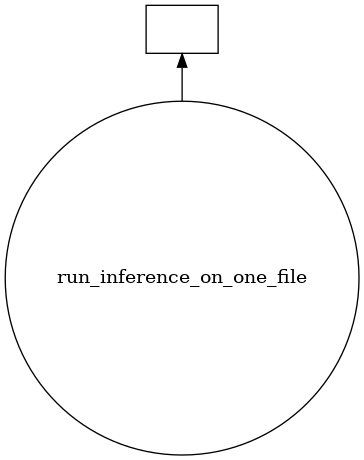

In [59]:
l_inference_files[0].visualize()

### Compute in parallel

To check progress manually, we can run this command from the CLI to count the number of output files:

```bash
ls "/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/" -l | wc -l
# 1473
```

In [66]:
%%time
dask.compute(l_inference_files)
# add print statement to prevent displaying a list of 5k None's
print('')

In [67]:
%%time

l_inference_files_created = glob.glob(f"{path_this_model_inference}/*.parquet")
len(l_inference_files_created)

CPU times: user 11.8 ms, sys: 4.66 ms, total: 16.5 ms
Wall time: 18.1 ms


5000

In [69]:
l_inference_files_created[:5]

['/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000001444.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000002951.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000002408.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000000405.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000004227.parquet']

## Test load an inference file
check column outputs

In [70]:
%%time
df_inf_check = pd.read_parquet(
    l_inference_files_created[0],
)
df_inf_check.shape

CPU times: user 209 ms, sys: 102 ms, total: 312 ms
Wall time: 225 ms


(462037, 7)

In [71]:
df_inf_check.head()

,pt,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code,user_id,click_proba
0,2023-05-29,de,t5_22i0,0,DE,t2_6qk7v6ig,0.036486
1,2023-05-29,de,t5_22i0,1,DE,t2_c1h49ro6k,0.064660
2,2023-05-29,de,t5_22i0,0,DE,t2_9jzw7gih,0.082675
3,2023-05-29,de,t5_22i0,0,DE,t2_bbo3h71gh,0.060558
4,2023-05-29,de,t5_22i0,1,DE,t2_fjwzq8gk,0.044669


## Upload predictions to GCS!
From GCS we can load it into BigQuery for final ranking & reshaping

In [84]:
path_this_model_inference

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference')

In [83]:
gcs_inference_out = f"{gcs_inference.rstrip('/')}_out/"
gcs_inference_out

'gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/'

In [86]:
!echo gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r -n $path_this_model_inference $gcs_inference_out
print('\n')

!echo gsutil -q -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r $path_this_model_inference $gcs_inference_out
print('\n')
!echo gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r $path_this_model_inference $gcs_inference_out 

gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r -n /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


gsutil -q -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


## Upload preddictions to BigQuery

By loading to a temp/staging table we can load data from multiple jobs in parallel and run the post-processing in BigQuery which will be faster than to customize in kubeflow

ETA: 2 minutes for 5k files:
```bash
Waiting on bqjob_r849e6f491213b41_000001887911b6cf_1 ... (109s) Current status: DONE
```

In [96]:
%%time

## bq load works, but won't read the "description" or other nice metadata from parquet files
!echo bq load \
    --source_format=PARQUET \
    --project_id=reddit-relevance \
    tmp.i18n_pn_predictions_raw \
    \""$gcs_inference_out"pred*.parquet\"

bq load --source_format=PARQUET --project_id=reddit-relevance tmp.i18n_pn_predictions_raw "gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/pred*.parquet"
CPU times: user 1.42 ms, sys: 332 ms, total: 334 ms
Wall time: 622 ms


In [91]:
%%time

!bq load \
    --source_format=PARQUET \
    --project_id=reddit-relevance \
    tmp.i18n_pn_predictions_raw \
    "$gcs_inference_out"pred*.parquet

BigQuery error in load operation: Access Denied: Project reddit-relevance: User
does not have bigquery.jobs.create permission in project reddit-relevance.
CPU times: user 20.1 ms, sys: 425 ms, total: 445 ms
Wall time: 1.96 s


# BigQuery processing
- rank the users
- reshape output
- save to staging table

# Redefine BQ table with correct schema partition should NEVER be null!

Updating with this schema fails... unclear why

In [104]:
from subclu.pn_models.bq_schemas import pn_model_schema
from subclu.utils.big_query_utils import create_partitioned_table_if_not_exist

In [106]:
%%time


create_partitioned_table_if_not_exist(
    bq_project='reddit-employee-datasets',
    bq_dataset='david_bermejo',
    bq_table_name='pn_model_output_20230601',
    schema=pn_model_schema(),
    partition_column='pt',
    partition_expiration_days=60,
    table_description=(
        "Cache model output with the users most likely to click on a PN from a target subreddit + target country"
    ),
)

02:58:22 | INFO | "Updating subreddit description from:
  Cache model output with the users most likely to click on a PN from a target subreddit + target country
to:
  Cache model output with the users most likely to click on a PN from a target subreddit + target country"
02:58:22 | INFO | "Created table reddit-employee-datasets.david_bermejo.pn_model_output_20230601"


CPU times: user 33.8 ms, sys: 641 ms, total: 674 ms
Wall time: 3.14 s


In [107]:
# %%time

# unclear why creating the table with this schema results in a __NULL__ partition ID when we update the table... sigh
# create_partitioned_table_if_not_exist(
#     bq_project='reddit-growth-prod',
#     bq_dataset='pn_targeting',
#     bq_table_name='pn_model_subreddit_user_click_v1',
#     schema=pn_model_schema(),
#     partition_column='pt',
#     partition_expiration_days=45,
#     table_description=(
#         "Cache model output with the users most likely to click on a PN from a target subreddit + target country"
#     ),
# )

03:06:52 | INFO | "Updating subreddit description from:
  Cache model output with the users most likely to click on a PN from a target subreddit + target country
to:
  Cache model output with the users most likely to click on a PN from a target subreddit + target country"
03:06:53 | INFO | "Created table reddit-growth-prod.pn_targeting.pn_model_subreddit_user_click_v1"


CPU times: user 28 ms, sys: 760 ms, total: 788 ms
Wall time: 3.29 s
